In [128]:
# there are two different ways to train a liner model 1 using a closed form equation and 2 using gradient descent
from copy import deepcopy
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from math import ceil
from sklearn.preprocessing import add_dummy_feature, StandardScaler, PolynomialFeatures
from sklearn.linear_model import (
    LinearRegression,
    SGDRegressor,
    Ridge,
    Lasso,
    ElasticNet,
    LogisticRegression,
)
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris

In [129]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

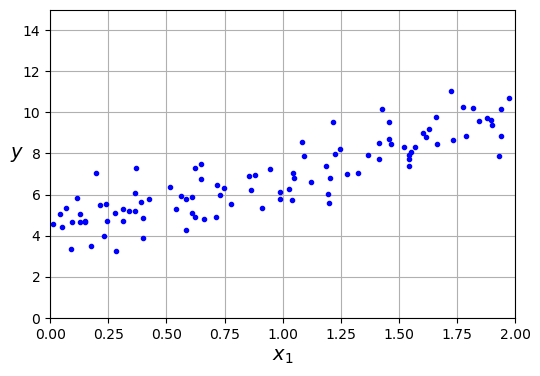

In [130]:
np.random.seed(42)
m = 100  # this is the number of instances
X = 2 * np.random.rand(m, 1)  # this is the column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # this is the column vector
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

In [131]:
# this is where we compute the theta hat using the normal equation (closed form equation)
X_b = add_dummy_feature(X)  # this add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best
# we would hope that theta_0 = 4 and theta_1 = 3 because that is what we used to generate the data but the smaller and noiser the data the less accurate the result will be

array([[4.21509616],
       [2.77011339]])

In [132]:
# now we can make predictions using theta hat
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # this add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

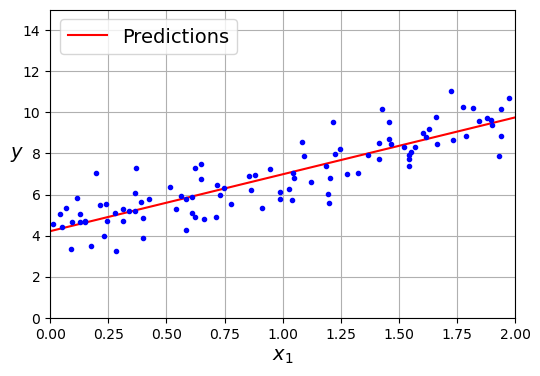

In [133]:
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

In [134]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("intercept:", lin_reg.intercept_, " coefficent:", lin_reg.coef_)
lin_reg.predict(X_new)

intercept: [4.21509616]  coefficent: [[2.77011339]]


array([[4.21509616],
       [9.75532293]])

In [135]:
# this is the what linear regression is doing under the hood
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd
# this function computes theta hat equals to X+ @ y where X+ is the pseudoinverse of X

array([[4.21509616],
       [2.77011339]])

In [136]:
# this computes the pseudoinverse directly
np.linalg.pinv(X_b) @ y
# the pseudoinverse is computed using a standard matrix factorization technique called Singular Value Decomposition (SVD) that can decompose the training set matrix X into the matrix multiplication of three matrices U @ Sigma @ V^T this may not work if the matrix is not invertible

array([[4.21509616],
       [2.77011339]])

GRADIENT DESCENT
BATCH GRADIENT DESCENT

In [137]:
eta = 0.1  # this is the learning rate
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization of the parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta

array([[4.21509616],
       [2.77011339]])

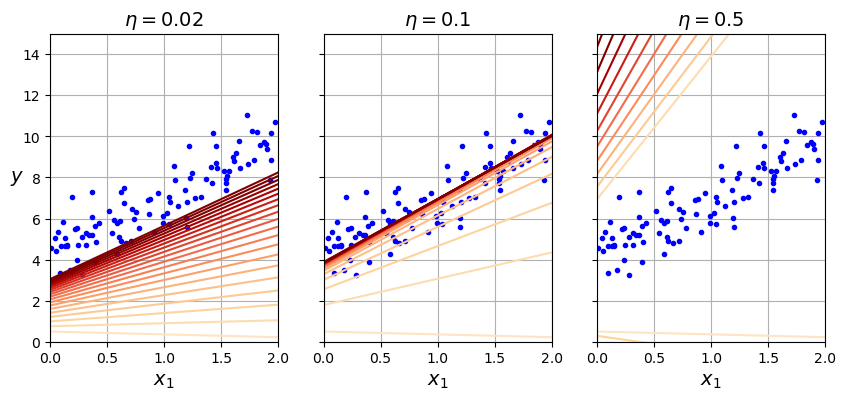

In [138]:
def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(rf"$\eta = {eta}$")
    return theta_path


np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

Stochastic Gradient Descent using a simple learning schedule

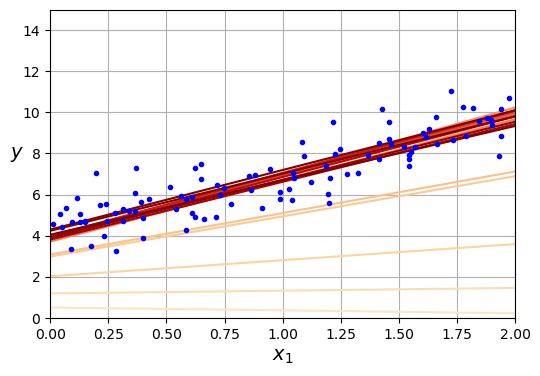

In [139]:
theta_path_sgd = []
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters


def learning_schedule(t):
    return t0 / (t + t1)


np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):
        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [140]:
theta

array([[4.21076011],
       [2.74856079]])

In [141]:
# using sk learn to perform SGD
# maximum of 1000 epochs, untill the loss drops by ess that 10^-5 (tolerance) during 100 epochs. it starts with a learning rate of 0.1 and uses the default learning schedule with no regularization
sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-5,
    penalty=None,
    eta0=0.01,
    n_iter_no_change=100,
    random_state=42,
)
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [142]:
print("intercept:", sgd_reg.intercept_, " coefficent:", sgd_reg.coef_)

intercept: [4.21278812]  coefficent: [2.77270267]


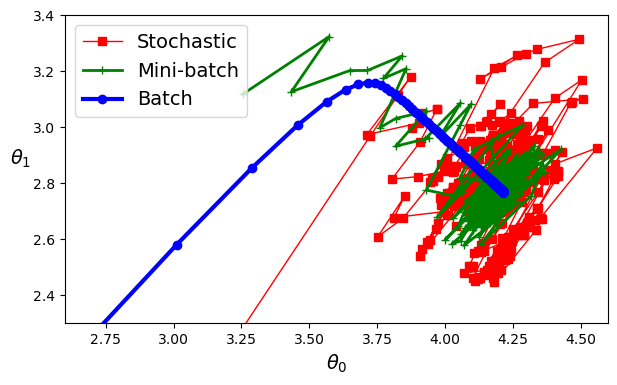

In [143]:
n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters


def learning_schedule(t):
    return t0 / (t + t1)


theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(
    theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic"
)
plt.plot(
    theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch"
)
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.show()

POLYNOMIAL REGRESSION

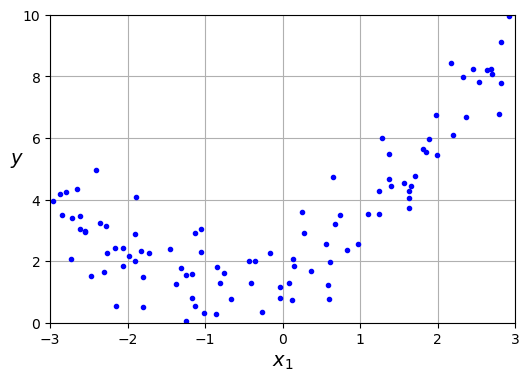

In [144]:
# if the data is more complex you an use a linear model to fit non linear data by adding powers called polynomial regression
# we will generate nolinear data based on a simple quadratic equation + some noise
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [145]:
# a straight line will never fit so we use sklearn's PolynomialFeatures class to transform our training data by adding the square of each feature in the training set as a new feature
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


intercept: [1.78134581] coefficients: [[0.93366893 0.56456263]]


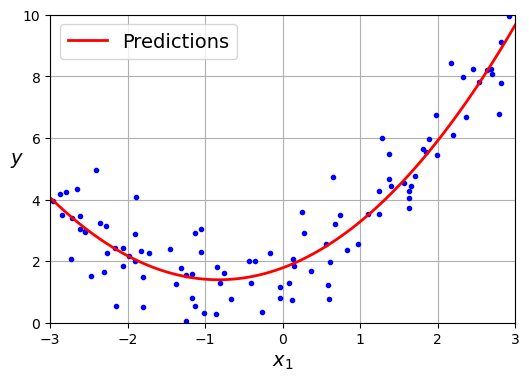

In [146]:
# x_poly now contains the original feature of X plus the square of this feature. now you can fit a LinearRegression model to this extended training data
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print("intercept:", lin_reg.intercept_, "coefficients:", lin_reg.coef_)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Learning Curves

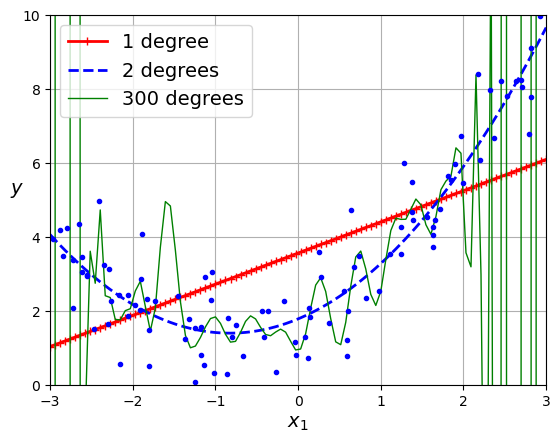

In [147]:
# below generates a 300 degree polynomial which is overfitting the data and a 1 degree polynomial which is underfitting the data so we want to know what degree is best
for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()

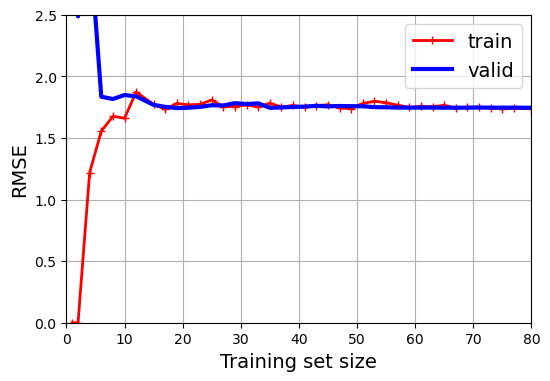

In [148]:
# this is an example fo the larning curve on the plain linear regression model
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()
# this model is underfitting the data becuase the training and validation curves have reached a plateau and are close together and fairly high so we need to use a more complex model

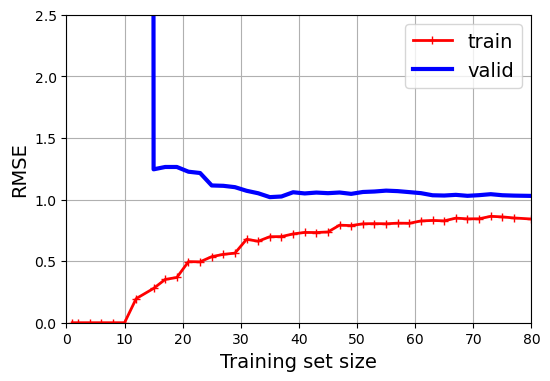

In [149]:
# this is an example of the learning curve on a 10th degree polynomial model
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False), LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()
# the error is much lower and there is a gap between the curves so this model is overfitting the data one way to improve an overfitting model is to feed it more training data until the validation error reaches the training error

REGULARIZED LINEAR MODELS


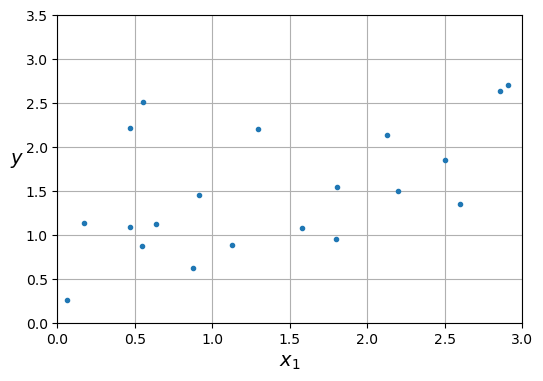

In [150]:
# a good way to reduce overfitting is to reularize the model a simple way to regularize a polynomial model is to reduce the number of polynomial degrees
# the first way of doing this is called ridge regression(Tikhonov regularization) which is a regularized version of linear regression
# we will generate some random data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [151]:
# using sklearn's Ridge class we can perform ridge regression with a closed-form solution
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

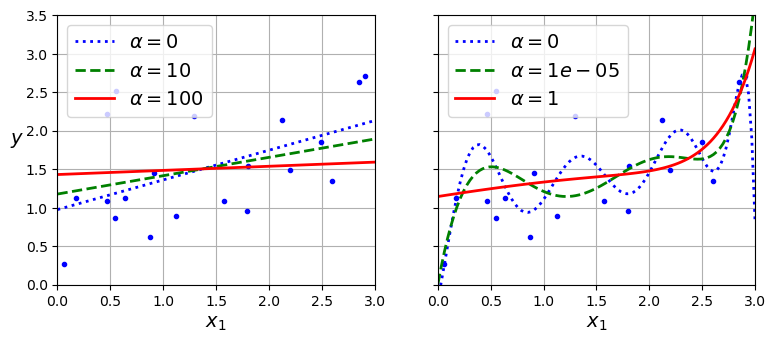

In [152]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model,
            )
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2, label=rf"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()


plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

In [153]:
# using sklearn's SGDRegressor class we can perform ridge regression with stochastic gradient descent
sgd_reg = SGDRegressor(
    penalty="l2", alpha=0.1 / m, tol=None, max_iter=1000, eta0=0.01, random_state=42
)  # specifying l2 indicates that you want SGD to add a regularization term to the cost function equal to half the square of the l2 norm of the weight vector: this is simply ridge regression
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

# RidgeCV class also performs ridge regression but it automatically tunes the hyperparameters using cross-validation

array([1.55302613])

LASSO REGRESSION
(Least Absolute Shrinkage and Selection Operator Regression)

[1.53788174]


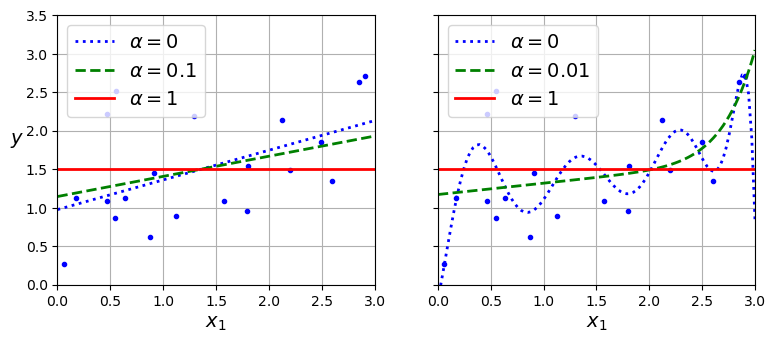

In [154]:
# this uses the l1 norm of the weight vector different norms lead to different factors
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print(lasso_reg.predict([[1.5]]))
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

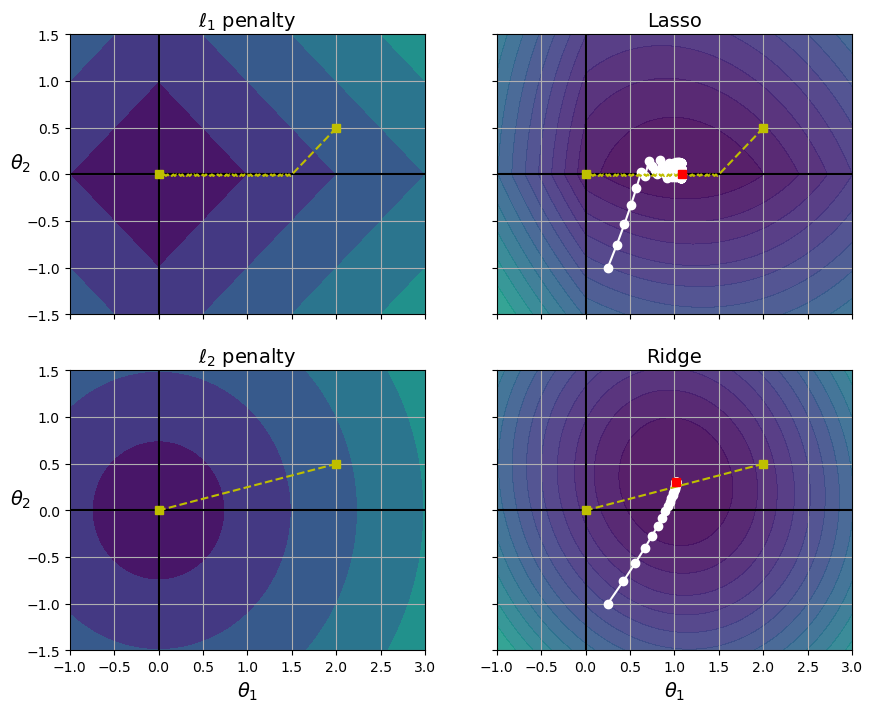

In [155]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])


def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (
            core * 2 / len(X) * X.T @ (X @ theta - y) + l1 * np.sign(theta) + l2 * theta
        )
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(
        theta=np.array([[2.0], [0.5]]),
        X=Xr,
        y=yr,
        l1=np.sign(l1) / 3,
        l2=np.sign(l2),
        core=0,
    )
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(rf"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
plt.show()

Elatic Net

In [156]:
# elstic net is a middle ground between rigde and lasso regression
# regularization term is a weighted sum of both ridge and lasso's regularization terms
# when r = 0, elastic net is equivalent to ridge regression and when r = 1, it is equivalent to lasso regression
# ridge is a good default but if you suspect that only a few features are actually useful, you should prefer lasso or elastic net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio corresponds to r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

Early Stopping

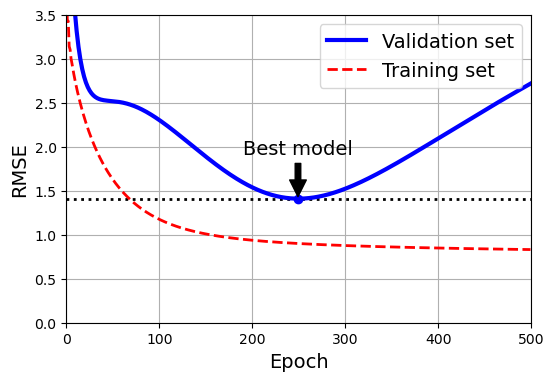

In [157]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False), StandardScaler()
)
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float("inf")
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates figure
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate(
    "Best model",
    xy=(best_epoch, best_valid_rmse),
    xytext=(best_epoch, best_valid_rmse + 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.05),
)
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

# this first adds the polynomial features then scales all the input features then creates a SGDRegressor and trains it on the scaled polynomial features

LOGISTIC REGRESSION

In [158]:
# logit regression is commonly used to estimate the probability that an instance belongs to a particular class such as "spam" or "not spam"
# it computes a weighted sum of the input features plus a bias term and outputs the logistic of the result which is a sigmoid function that outputs a number between 0 and 1
# we use the iris dataset to illustrate logit regression
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [159]:
iris.data.head(3)  # know that the instances arnt shuffled

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [160]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [161]:
X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

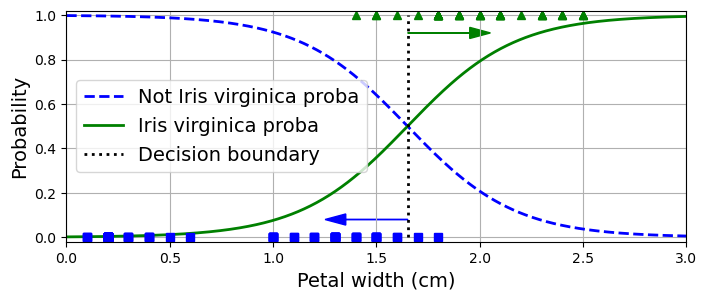

In [162]:
X_new = np.linspace(0, 3, 1000).reshape(
    -1, 1
)  # this reshapes the array to be a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][
    0, 0
]  # this finds the first instance where the probability is greater than or equal to 0.5

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot(
    [decision_boundary, decision_boundary],
    [0, 1],
    "k:",
    linewidth=2,
    label="Decision boundary",
)

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(
    x=decision_boundary,
    y=0.08,
    dx=-0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="b",
    ec="b",
)
plt.arrow(
    x=decision_boundary,
    y=0.92,
    dx=0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="g",
    ec="g",
)
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
plt.show()
# gives the cumulative probability that an instance belongs to a certain class (in this case virginica) given the input features

In [163]:
print(decision_boundary)
log_reg.predict([[1.7], [1.5]])
# the hyperparameter controlling the regularization is not alpha but its inverse C the higher the value of C the less the model is regularized

1.6516516516516517


array([ True, False])

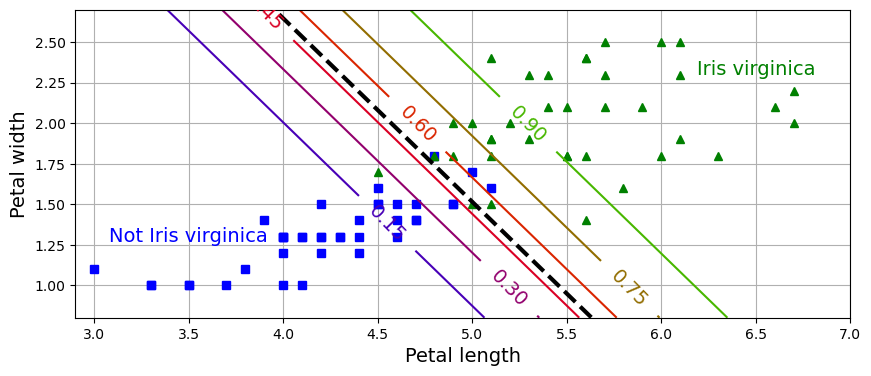

In [164]:
# extra code this just show the decision boundary with width and length
# all flowers beyond the gree line have over a 90% chance of being virginica according to the model
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 500).reshape(-1, 1), np.linspace(0.8, 2.7, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -(
    (log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0, 1]
)

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

SOFTMAX REGRESSION

In [165]:
# the logistic regression model can be generalized to supporet multiple classes directly without having to train and combine multiple binary classifiers
# each class has its own dedicated parameter vector and the classifiers estimates a probability for each class these vectors are typically stored as rows in a parameter matrix
# the softmax classifier or multinomial logistic regression classifier is a generalization of the logistic regression classifier to support multiple classes directly
# the cost function is the cross entropy which penalizes the model when it estimates a low probability for a target class
# cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(
    C=30, random_state=42
)  # C is the inverse of alpha it is the regularization hyperparameter
softmax_reg.fit(X_train, y_train)
softmax_reg.predict([[5, 2]])

array([2])

In [166]:
print("cutoff probabilites:", softmax_reg.predict_proba([[5, 2]]).round(2))

cutoff probabilites: [[0.   0.04 0.96]]


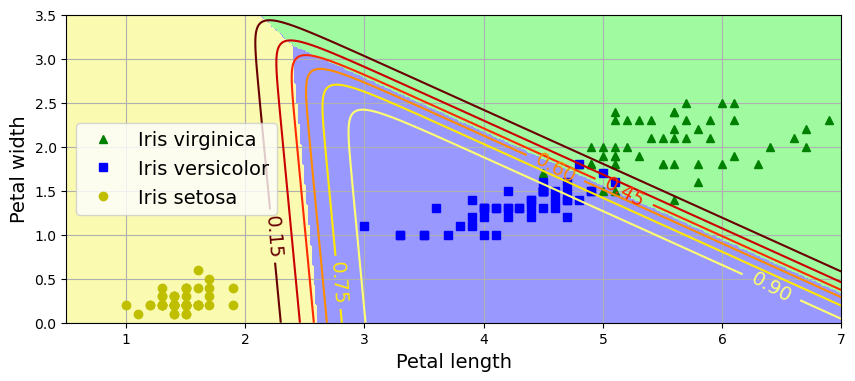

In [168]:
# extra code
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1), np.linspace(0, 3.5, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
plt.show()